# `wisesight-sentiment` Exploration by [@lukkiddd](https://github.com/lukkiddd)

This notebook perform an exploration of the `wisesight-sentiment` dataset which was provided by **Wisesight (Thailand) Co., Ltd**. It contains 24,063 texts with 4 categories (q-uestion, neg-ative, neu-tral, and pos-itive) for training set and 2,674 texts for test set. For more detail about the data you can read at `README.md` file.
    
- Read file
- Number of tokens distribution
- TF-IDF
    - Words
    - Emojis
    - Punc
    - URL
    - Hashtags

In [8]:
import codecs
import re
import pandas as pd

from tqdm import tqdm_notebook

from pythainlp.tokenize import word_tokenize

#viz
import seaborn as sns

from matplotlib import pyplot as plt

#params
pd.set_option("max_colwidth", 0)
sns.set_context("talk")
sns.set_palette(sns.color_palette("colorblind", 10))

%matplotlib inline

In [12]:
# Thai font is needed
# Copy thsarabunnew-webfont.ttf to the notebook directory

#snippet to install thai font in matplotlib from https://gist.github.com/korakot/9d7f5db632351dc92607fdec72a4953f
import matplotlib

# !wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
# !cp thsarabunnew-webfont.ttf /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/
# !cp thsarabunnew-webfont.ttf /usr/share/fonts/truetype/

matplotlib.font_manager._rebuild()
matplotlib.rc('font', family='TH Sarabun New')

# Reading data

In [66]:
#train.csv
texts = []
labels = []
with codecs.open('train.txt', encoding='utf-8') as f:
    for line in f.read().split('\n'):
        texts.append(line.strip())
f.close()
with open(f"train_label.txt") as f:
    for line in f.read().splitlines():
        labels.append(line)
f.close()
df = pd.DataFrame({'category':labels,'texts':texts[:-1]})
df.to_csv('train.csv',index=False)
df.shape

(24345, 2)

In [67]:
#test.csv
texts = []
labels = []
with codecs.open('test.txt', encoding='utf-8') as f:
    for line in f.read().split('\n'):
        texts.append(line.strip())
f.close()

test_df = pd.DataFrame({'category': 'neu','texts':texts[:-1]})
test_df.to_csv('test.csv',index=False)
test_df.shape

(3946, 2)

In [13]:
df.describe()

,category,texts
count,24345,24345
unique,4,24183
top,neu,งื้ออออ
freq,14243,2


In [14]:
df.groupby("category").describe()

texts         \
          count unique   
category                 
neg       5713   5713    
neu       14243  14243   
pos       3917   3917    
q         472    472     

                                                                                                                                                                                                                                                                                                       \
                                                                                                                                                                                                                                                                                                  top   
category                                                                                                                                                                                                                                                                                                
neg       กินดีกว่า285...นุ่มกว่าและไม่เมาค้าง                                                                                                                                                                                                                                                          
neu       แน่นอน5555                                                                                                                                                                                                                                                                                    
pos       วิธีการสื่อสารกับเด็กๆ ของ อ.ปิยบุตร น่าสนใจ น้ำเสียงสบายๆ ดูไม่ประดิษฐ์ ขายของไปเรื่อยๆ เด็กถามก็ตอบธรรมดาๆ ไม่รู้สึกถึงการยัดเยียด ดูจากรีแอคชั่นของเด็กเห็นได้ว่าเด็กสบายใจที่จะคุยด้วย และที่ดีมากคือแม้เด็กอาจจะอายุไม่ถึงวัยเลือกตั้ง แต่ใช้เวลาพูดคุยด้วย pic.twitter.com/pB3s0QUUmD   
q         ขอนุญาตินอกเรื่องกูข้องใจนานละ เมื่อไหร่sextoy บุหรี่ไฟฟ้าจะถูกกฏหมายแบบญี่ปุ่นหรือประเทศอื่น                                                                                                                                                                                                 

               
         freq  
category       
neg       1    
neu       1    
pos       1    
q         1

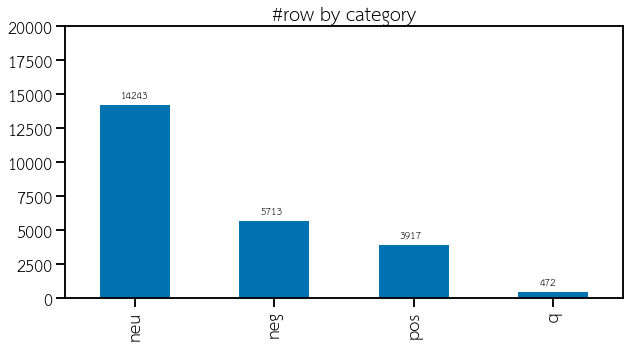

In [15]:
row_count_by_category = df.category.value_counts()
ax = row_count_by_category.plot("bar", title="#row by category", figsize=(10, 5))
ax.set_ylim(0, 20000)
for i, label in enumerate(row_count_by_category):
    ax.annotate(str(label), (i-0.1, label + 500))

# Text length

In [16]:
df['length'] = df['texts'].apply(word_tokenize).apply(len)
df.head()

,category,texts,length
0,neu,10 ประโยชน์ของฮับมะกอก เกรด A จากตุรกี 1. ช่วยรักษาโรคเบาหวานและความดัน 2. ช่วยป้องกัน และรักษาโรคหัวใจ 3. ช่วยป้องกัน และรักษาโรคมะเร็ง 4. ช่วยบำรุงผิวพรรณแบบ Inside-Out 5. ช่วยบำรุงสมอง และป้องกันโรคอัลไซเมอร์ 6. ช่วยละลายไขมันในร่างกาย 7. ช่วยกำจัดแบคทีเรียและเชื้อราในร่างกาย 8. ช่วยรักษาโรคในท้อง เช่นท้องเสีย หรืออาหารเป็นพิษ 9. ช่วยบรรเทาอาการปวดเมื่อย และรักษาโรคเหน็บชา 10. ช่วยรักษาอาการภูมิแพ้ และโรคไซนัส,113
1,neg,ขับอัลติส1.8/141ม้า บางทีเจอกะบะกะพริบไฟใร่ตามหลัง หรือบางทีกะบะแข่งกันมาพอเราทำให้ดูมั่งไม่เห็นใครตามมาเลย พอไปเจอเราที่ปั้มมีแอบมองด้วย,42
2,neu,อยู่แบบนี้กันไปนานๆนะ อยู่เป็นเพื่อนในเหงา อยู่เป็นแฟนในอยามว่าง อยู่เป็นพ่อครัวในยามกูหิว อยู่เป็นพ่อ-แม่ในยามกูหัวร้อน แล้ววันที่ 31 เจอกันในวันที่ 31 ธันวานี้ >> อยากอยู่กับคนพิเศษ พิเศษในคืนข้ามปี (ถ้าไม่ได้เราไปสวดมนต์ข้ามปีแทน ฮ่า) #ช้าง #chand #tbc2018,89
3,neu,ข้างหลังเลียนแบบ mg3ชัดชัด,7
4,neu,",, อยาก ชีวิตดีกับ BLEND285 จัง เลยจ๊ะพี่จ๋า",17


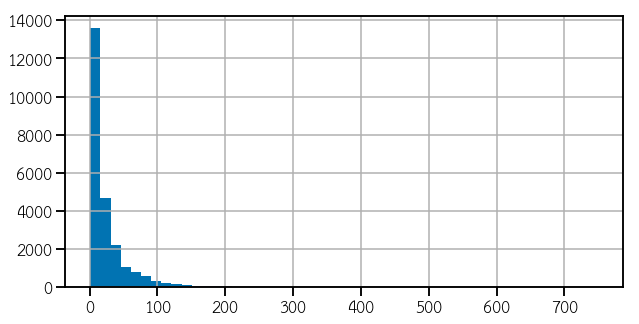

In [17]:
df['length'].hist(bins=50, figsize=(10, 5))

In [18]:
df['length'].describe()

count    24345.00000
mean     27.65648   
std      44.69065   
min      1.00000    
25%      6.00000    
50%      13.00000   
75%      30.00000   
max      749.00000  
Name: length, dtype: float64

In [19]:
df[df['length'] >= 749]

,category,texts,length
4184,neu,"และงานใหญ่ประจำปี บ้ตร sold out ทุกปี - ขายบัตรแล้ว!! พร้อมเพิ่มวง LIPTA - ถึงเวลารวม ชนเผ่า Johnnie Walker present 20Something On The Beach 2018 ""ชน เผ่า เมา เต้น"" ▶ THAITANIUM ▶ UrboyTJ ▶ COCKTAIL ▶ MILD ▶ LIPTA ▶ MUSKETEERS X BETTERWEATHER ▶ บริษัทฮาไม่จำกัด (บอล,ค่อม,ตั๊ก,โรเบิร์ต สายควัน) ▶ Dj Taidy Dj MMM Mc YongHulk ▶ GiraffNoi / RAVEN DOLL PARTY แบบ nonstop ไม่มี dead air DJ สลับ ศิลปินตลอดงาน @The Zign pattaya Sat 03/03/2018 16.00 - until late AGE : 18+ Dress Code : ชนเผ่า ----------------------------------------------- งานแบ่งเป็น 2 zone * Zone Regular : อยู่ด้านหลังไม่ติดเวที มีโต๊ะให้บางส่วน ไม่มีการจอง มาก่อนได้ก่อน ไม่ได้มีพอกับทุกคน เข้า zone vip ไม่ได้ (บัตรทุกราคา free mixer all night) * Regular Ticket - Pre sale : 900 ฿ - Door sale : 1,200 ฿ * Regular Package : 4,900฿ (ไม่มีบุ๊คโต๊ะ ไปก่อนได้ก่อน) - ห้องพัก the zign 1 ห้อง - บัตร regular 2 ใบ - บัตรอาหารเช้า 2 ท่าน — *Zone VIP : อยู่ด้านหน้าติดเวที Zone นี้ทุกโต๊ะจะต้องจองเท่านั้น สำหรับคนที่ ซื้อบัตร vip แยกเป็นใบๆ ต้องมีเพื่อนจองโต๊ะแล้วเท่านั้น ไม่งั้นเข้าไป คุณจะไม่มีโต๊ะ * VIP Ticket (limited) - 1,500 ฿ * VIP Package A : 15,000 ฿ (มีบุ๊คโต๊ะ) - ห้องพัก the zign 1 ห้อง - บัตร vip 4 ใบ - Whisky Johnnie Walker Blenders’ Batch 2 ขวด - Reserve table + VIP toilet - เด็กเสริฟ เครื่องดื่ม - Free mix all night - บัตรอาหารเช้า 2 ท่าน * VIP Package B : 12,000 ฿ (มีบุ๊คโต๊ะ) (สำหรับคนไม่เอาห้อง) - บัตร vip 4 ใบ - Whisky Johnnie Walker Blenders’ Batch - Reserve table + VIP toilet - เด็กเสริฟ เครื่องดื่ม - Free mix all night * VIP Package C : 6,100 ฿ (ไม่มีบุ๊คโต๊ะ) (สำหรับคนที่เพื่อนซื้อโต๊ะแล้ว) - ห้องพัก the zign 1 ห้อง - บัตร vip 2 ใบ - VIP toilet - เด็กเสริฟ เครื่องดื่ม - Free mix all night - บัตรอาหารเช้า 2 ท่าน ----------------------------------------------- ซื้อบัตรคลิก : http://go.eventpop.me/20STHONTHEBEACH2018 ซื้อบัตรกับทางร้าน (เฉพาะโต๊ะ vip zone ครึ่งหลัง) LINE@20sth : https://goo.gl/ujgAK4 Party by ""20STH TEAM"" #20somethingonthebeach2018 #20somethingonthebeach #ชนเผ่าเมาเต้น",749


### Word length distribution

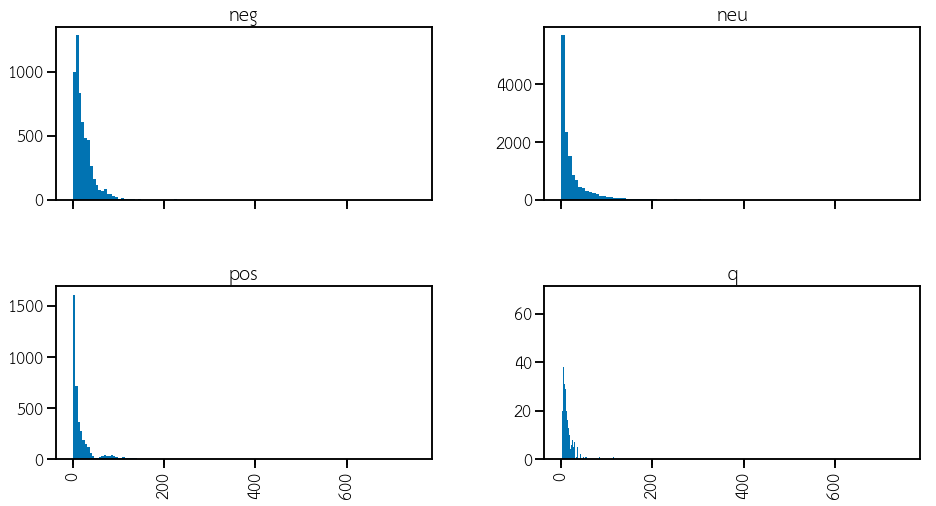

In [20]:
df.hist(column='length', by='category', bins=100, figsize=(15,8), sharex=True)
plt.show()

### Word length distribution (< 100)

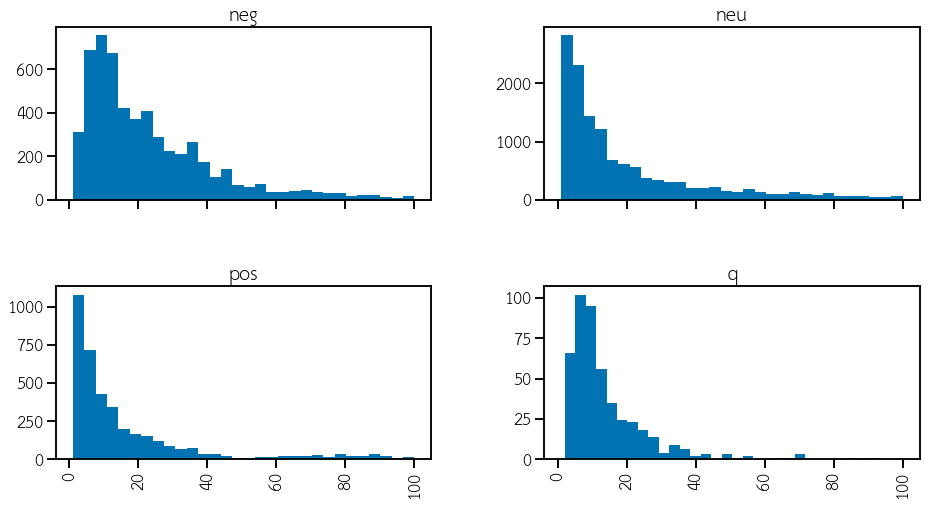

In [21]:
df[df['length'] <= 100].hist(column='length', by='category', bins=30, figsize=(15,8), sharex=True)
plt.show()

# Preprocess

In [22]:
def top_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'score']
    return df

In [23]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_feats(tfidf_means, features, top_n)

In [24]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    ''' Return a list of dfs, where each df holds top_n features and their mean tfidf value
        calculated across documents with the same class label. '''
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [25]:
def plot_classfeats_h(dfs, score_name=''):
    ''' Plot the data frames returned by the function plot_tfidf_classfeats(). '''
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel(f"Mean {score_name} Score", labelpad=16, fontsize=14)
        ax.set_title("label = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#3F5D7D')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        ax.invert_yaxis()
        yticks = ax.set_yticklabels(df.feature)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [26]:
def show_classfeats(df, vectorizer, analyzer, score_name='', text_col='texts', class_col='category', is_emoji=False):
    vec = vectorizer(analyzer=analyzer)
    mat = vec.fit_transform(df[text_col])
    dfs = top_feats_by_class(mat, df[class_col], vec.get_feature_names())
    if is_emoji:
        for dataframe in dfs:
            dataframe.columns = [dataframe.label, 'tfidf_' + dataframe.label]
        return pd.concat(dfs, axis=1)
    else:
        plot_classfeats_h(dfs, score_name=score_name)

In [27]:
import string
import emoji
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def process_text(text):
    nopunc = [char for char in text if char not in string.punctuation]
    nopunc = ''.join(nopunc)
    
    return [word for word in word_tokenize(nopunc) if word and not re.search(pattern=r"\s+", string=word)]

def extract_url(text):
    URL_PATTERN = r"(https?:\/\/)?\.([\da-z-]+)\.([a-z\.]{2,6})([\/\w\.-]*)*\/?\S"
    return [url[1] for url in re.findall(pattern=URL_PATTERN, string=text.lower())]

def extract_emojis(str):
    return [c for c in str if c in emoji.UNICODE_EMOJI]

def extract_punc(text):
    return [char for char in text if char in string.punctuation]

def extract_hashtags(text):
    HASHTAG_PATTERN = r"#[a-zA-Z0-9ก-๙]+"
    return re.findall(pattern=HASHTAG_PATTERN, string=text)

## TF-IDF

### word

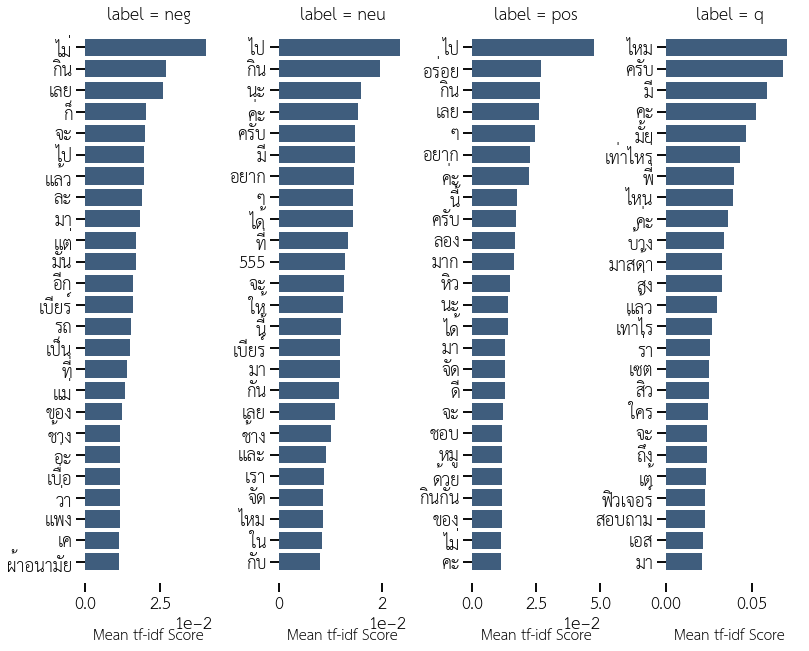

In [28]:
show_classfeats(
    df=df[:1000],
    vectorizer=TfidfVectorizer,
    analyzer=process_text,
    score_name="tf-idf",
)

### emojis

In [29]:
show_classfeats(df=df, vectorizer=TfidfVectorizer, score_name="tf-idf", analyzer=extract_emojis, is_emoji=True)

,neg,tfidf_neg,neu,tfidf_neu,pos,tfidf_pos,q,tfidf_q
0,😂,0.018295,😂,0.009092,😂,0.014057,😂,0.009283
1,😭,0.010912,😍,0.004942,😍,0.009682,🤔,0.004237
2,🤣,0.003902,❤,0.004359,😁,0.008336,😍,0.004237
3,😅,0.003066,😁,0.004216,❤,0.005888,😭,0.004077
4,🙄,0.002750,🤣,0.003759,😘,0.005599,👀,0.002119
5,😢,0.002537,🙏,0.003651,😋,0.005160,🙏,0.002119
6,😁,0.002174,😊,0.003559,😆,0.004507,😋,0.002119
7,😡,0.002046,😘,0.003516,👍,0.003416,😮,0.002119
8,😆,0.001783,👉,0.002908,🙏,0.003391,😩,0.002119
9,😒,0.001665,🎉,0.002376,😊,0.003239,😙,0.002119


### punctuation

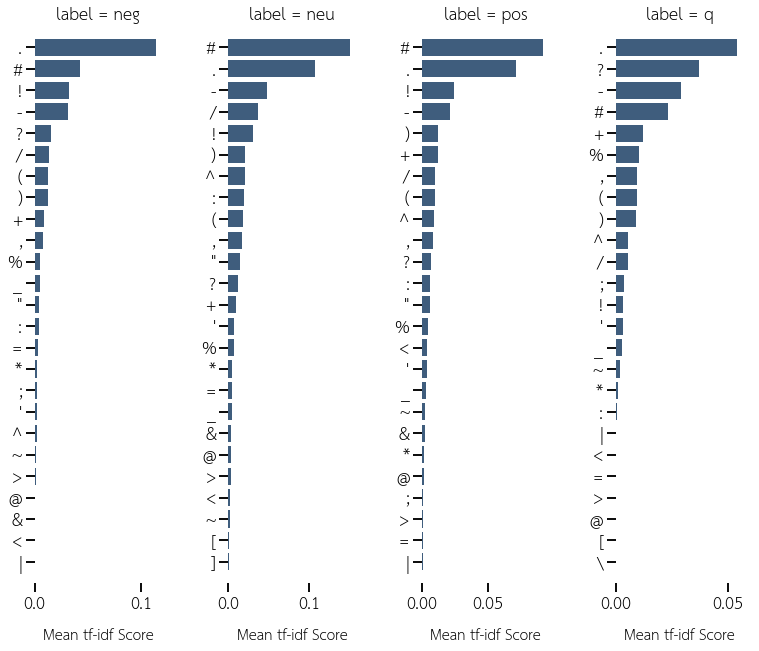

In [30]:
show_classfeats(df=df, vectorizer=TfidfVectorizer, score_name="tf-idf", analyzer=extract_punc)

### URL

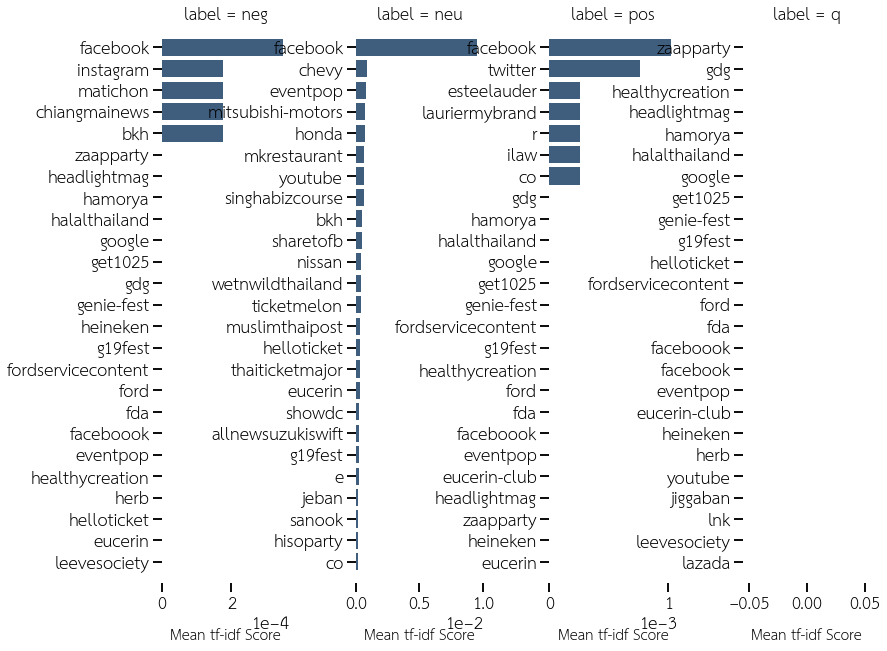

In [31]:
show_classfeats(df=df, vectorizer=TfidfVectorizer, score_name="tf-idf", analyzer=extract_url)

### Hashtags

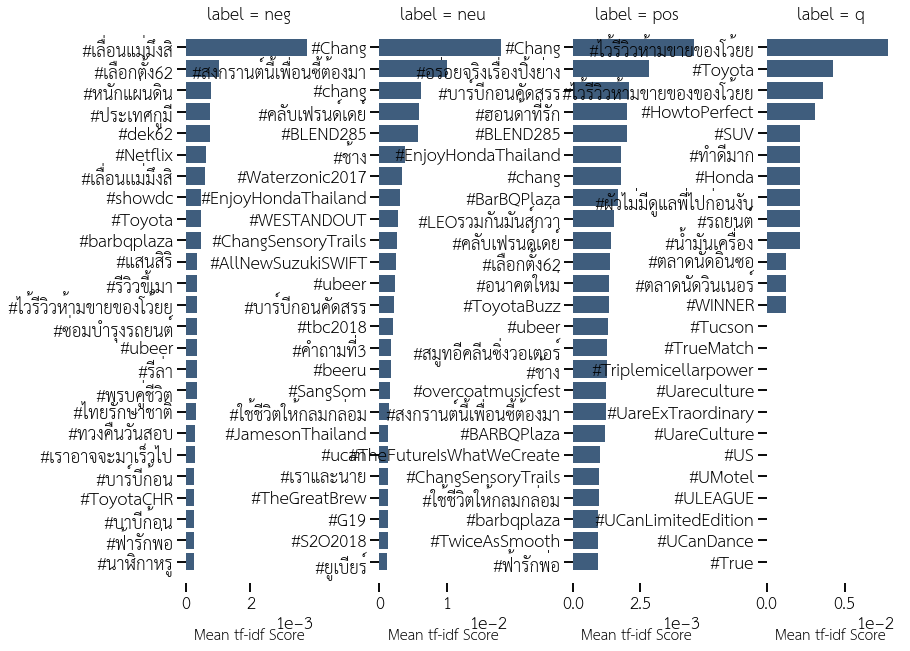

In [32]:
show_classfeats(df=df, vectorizer=TfidfVectorizer, score_name="tf-idf", analyzer=extract_hashtags)

# Neutral, Positive, Negative

In [33]:
neu_df = df[df.category == "neu"].sample(5000)
neu_df.head()

,category,texts,length
16477,neu,เหนื่อยด้วยกันมาทั้งปี ไปดูหนังด้วยกันทั้งทีมก็ดีเหมือนกัน!!! #StarDelivery #Heineken #OpenYourWorld,22
10547,neu,อะไรที่ผิดท่ามักพาให้ปวดหลัง! หลายคนอาจจะมีอาการปวดหลัง ตื่นนอนขึ้นมา ยังไม่ได้ทำอะไรเลยก็ปวดหลังซะแล้ว แบบนี้ มันอาจจะเกิดจากท่านอนของเราเองก็ได้นะ ลองมาดูท่านอนที่ช่วยลดปัญหาปวดหลังกันเถอะ แล้วคืนนี้มาลองปรับท่านอนกันใหม่ เพื่อสุขภาพที่ดีของหลังเรา 📍ศึกษาข้อมูลเพิ่มเติม คลิก!! : https://goo.gl/W39Pui 📍📍สอบถามข้อมูลเพิ่มเติม : https://goo.gl/VXrnnY 📞 Samitivej Call Center 020-222-222 #SamitivejHospital #โรงพยาบาลสมิติเวช #แก้ตรงจุดหยุดปวดหลัง,135
18455,neu,ช้างหรือลีโอครับพี่ ผมกินช้างอยุ่ตอนนี้,12
19305,neu,อยากทำบัตรสมาชิก ขอรายระเอียด ด้วยนะ ไปกินทุกครั้งไม่เคยทำเลย,20
15394,neu,ไม่เอาอะ อาย,4


In [34]:
pos_df = df[df.category == "pos"]
pos_df.head()

,category,texts,length
9,pos,ก็น่าจะอร่อยนะ ดูจากรูปแล้ว เนื้อน่ากินสุดๆ เหมือนบาบีคิวพลาซ่า,19
15,pos,ไม่ว่าเมนูไหนของBarBQ Plaza ก็อร่อยถูกใจทั้งนั้น😉ยิ่งช่วงวันหยุดเวลาดีดีที่ได้อยู่กับครอบครัวได้ทานอาหารอร่อยๆพร้อมหน้าพร้อมตาคงมีความสุขที่สุด •ถ้าได้รางวัลจะสั่งชุดเนื้อค่ะ ส่วนเมนูให้เลือกคงเป็นปลาแซลมอนนอร์เวร์ ปล.ยิ่งได้รางวัลยิ่งแฮปปี้ค่ะ🐉,64
49,pos,อยากกินนนน,3
55,pos,ไม่รุ้ว่าเลยลดม้ะ,6
73,pos,อยากไปวิ่งกับ VINAI อีก วันนั้นฉันจะวิ่งเข้าป่า555 รับลองวิ่งแน่งานนี้พี่ ไปกัน #BangkokOfDreams #BLEND285 #Findyourjoy #ใช้ชีวิตให้กลมกล่อม,42


In [35]:
neg_df = df[df.category == 'neg']
neg_df.head()

,category,texts,length
1,neg,ขับอัลติส1.8/141ม้า บางทีเจอกะบะกะพริบไฟใร่ตามหลัง หรือบางทีกะบะแข่งกันมาพอเราทำให้ดูมั่งไม่เห็นใครตามมาเลย พอไปเจอเราที่ปั้มมีแอบมองด้วย,42
14,neg,นี่เป็นคนขับรถเร็วเวลาอยู่คนเดียว ยิ่งเป็นทางที่ขับบ่อยๆเหยียบไปเลย 100-120 ต่อไปนี้จะไม่ขับไวแล้วเพราะยาริสนี่คงไ…,33
17,neg,อ่านเม้นดิมีเจอแมลงสาปในเตาด้วย บางคนก็เจอไต่อยู่ใกล้ๆ,18
20,neg,ขออนุญาติฝากร้านค่ะ ใครที่มีปัญหาตกขาว ปวดท้อง ปวดหลัง ระคายเคืองเวลาใช้ผ้าอนามัย ลองมาใช้บิวตี้คอมฟอร์ทสิแล่วจะติดใจ สนใจทักทายมาเลยค้า,37
28,neg,โบกแท็กซี่สิบคันไม่ไปซักคัน,8


In [36]:
sentiment_df = pd.concat([neg_df, pos_df, neu_df])
sentiment_df = sentiment_df.reset_index(drop=True)
sentiment_df.groupby('category').texts.describe()

,count,unique,top,freq
category,,,,
neg,5713,5713,กินดีกว่า285...นุ่มกว่าและไม่เมาค้าง,1
neu,5000,5000,[[ ซื้อรองพื้นคู่กันแดด KMA ลดเหลือ 590 บาท จากปกติ 740 บาท ]],1
pos,3917,3917,วิธีการสื่อสารกับเด็กๆ ของ อ.ปิยบุตร น่าสนใจ น้ำเสียงสบายๆ ดูไม่ประดิษฐ์ ขายของไปเรื่อยๆ เด็กถามก็ตอบธรรมดาๆ ไม่รู้สึกถึงการยัดเยียด ดูจากรีแอคชั่นของเด็กเห็นได้ว่าเด็กสบายใจที่จะคุยด้วย และที่ดีมากคือแม้เด็กอาจจะอายุไม่ถึงวัยเลือกตั้ง แต่ใช้เวลาพูดคุยด้วย pic.twitter.com/pB3s0QUUmD,1


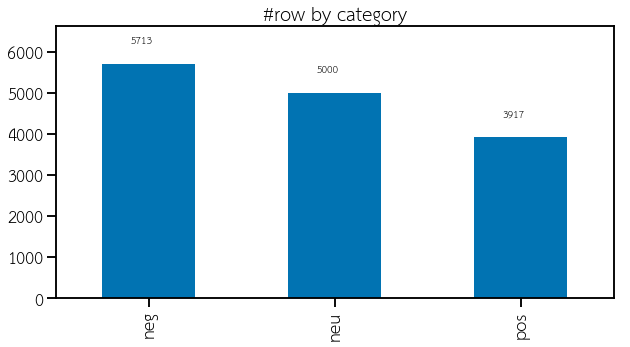

In [37]:
row_count_by_category = sentiment_df.category.value_counts()
ax = row_count_by_category.plot("bar", title="#row by category", figsize=(10, 5))
ax.set_ylim(0, row_count_by_category.max() + row_count_by_category.std())
for i, label in enumerate(row_count_by_category):
    ax.annotate(str(label), (i-0.1, label + 500))

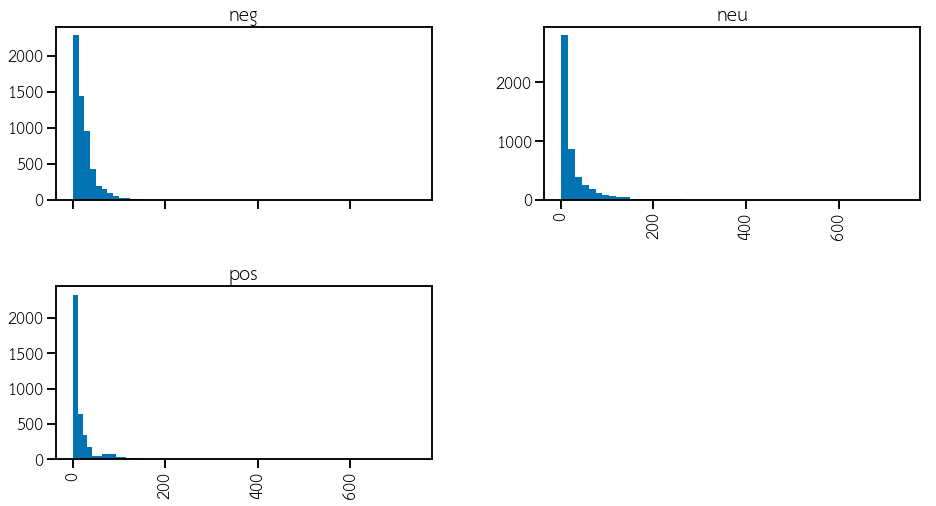

In [38]:
sentiment_df.hist(column='length', by='category', bins=50, figsize=(15, 8), sharex=True)
plt.show()

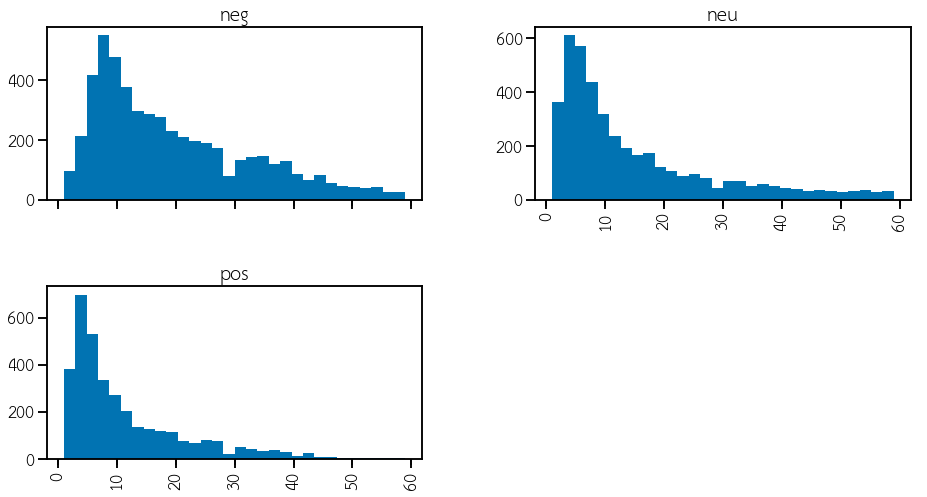

In [39]:
sentiment_df[sentiment_df.length < 60].hist(column='length', by='category', bins=30, figsize=(15, 8), sharex=True)
plt.show()

# Classification

In [40]:
class_names = np.unique(sentiment_df.category).tolist()

## Multinomial Naive Bayes (default parameters)

In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sentiment_df['texts'], sentiment_df['category'], test_size=0.20, random_state=42)

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

text_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=process_text, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB(alpha=0.001)),
])

text_clf.fit(X_train, y_train)
text_clf.score(X_test, y_test)

0.6326042378673957

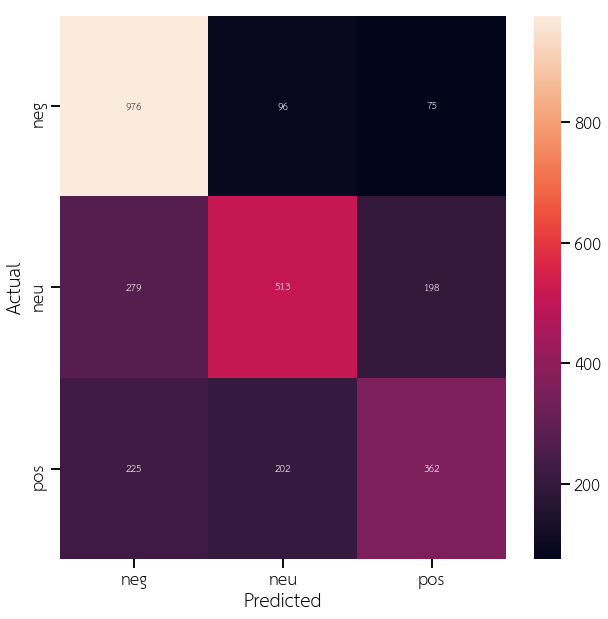

In [43]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, text_clf.predict(X_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

#### LIME Explainer

In [61]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=class_names)

In [62]:
idx = sentiment_df.sample(1).index[0]

exp = explainer.explain_instance(sentiment_df.texts[idx], text_clf.predict_proba, num_features=5, top_labels=1)
exp.show_in_notebook()

/usr/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [63]:
sentiment_df.iloc[idx]

category    pos                 
texts       อยากกินเอมเคคคคคคคคค
length      8                   
Name: 7851, dtype: object

## Linear SVC (default parameters)

In [64]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC

svc_clf = Pipeline([
    ('vect', CountVectorizer(tokenizer=process_text, ngram_range=(1,2))),
    ('tfidf', TfidfTransformer()),
    ('clf', LinearSVC()),
])

svc_clf.fit(X_train, y_train)
svc_clf.score(X_test, y_test)

0.6630211893369788

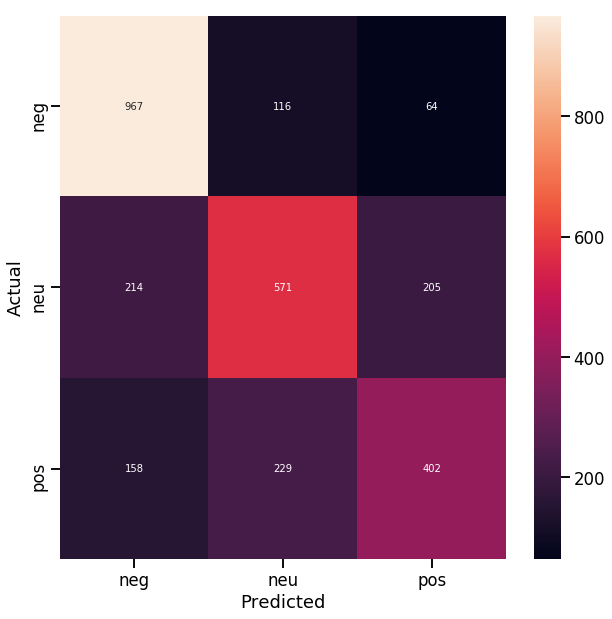

In [65]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, svc_clf.predict(X_test))
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()